# Определение возраста покупателей

## Исследовательский анализ данных

Импортируем необходимые библиотеки.

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator

Загрузим данные. Приведём значения интенсивностей пикселей изображений к диапазону 0-1, а сами изображения к разрешению 224:224. При загрузке будем разбивать изображения на пакеты по 32 изображения.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345
)

features, target = next(train_gen_flow)

Found 7591 validated image filenames.


Выведем размерность пакета признаков.

In [3]:
features.shape

(32, 224, 224, 3)

Посмотрим статистическое описание целевого признака (возраст).

In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Половина фотографий принаддежит молодым людям до 30 лет. Средний возраст - 31 год.
Проанализируем возраст людей на фото по гистограмме.

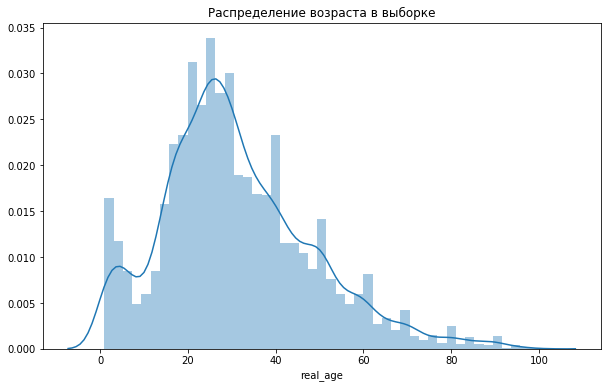

In [5]:
plt.figure(figsize=(10,6))
sns.distplot(labels.real_age)
plt.title('Распределение возраста в выборке');

Видно, что на детских фото больше дошкольников, чем детей школьного возраста. Правая часть распределения похожа на общую статистику распределения по возрастам.

Выведем первые двенадцать фотографий.

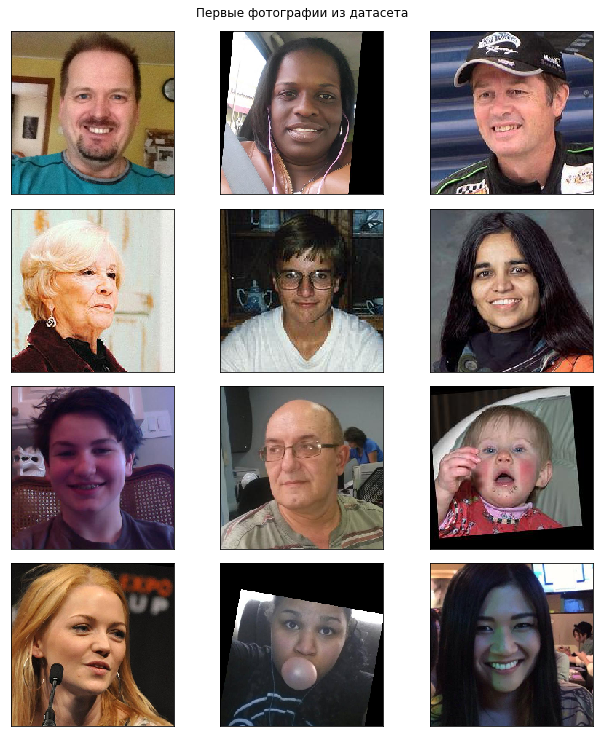

In [6]:
fig = plt.figure(figsize=(10,10))
plt.suptitle('Первые фотографии из датасета', y=1.02)
for i in range(12):
    fig.add_subplot(4, 3, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Заметим разный наклон и угол поворота лиц, есть повёрнутые фотографии, также некоторые лица частично перекрыты, но, думаю, это не должно критически сказаться на качестве обучения нейронной сети.

## Обучение модели

* В качестве модели возьмём ResNet с 50 слоями из библиотеки keras.
* Вместо вершины по умолчанию добавим слой пулинга по среднему и слой с одним нейроном с активацией ReLU.
* Оптимизатор - Adam, со скоростью обучения 0.0001.
* В качестве функции потерь будем использовать среднеквадратичную ошибку, а метрикой будет средняя абсолютная ошибка, значение которой должно быть не больше 8 на тестовой выборке.
* Данные разобъём на обучающее и тестовое подмножества в соотношении 3:1.
* Количество эпох = 20.

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd

RANDOM_SEED = 12345

def load_train(path):
    labels = pd.read_csv(path + '/labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)

    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=RANDOM_SEED)

    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + '/labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)

    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=RANDOM_SEED)

    return test_datagen_flow

def create_model(input_shape):
 
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.
Train for 178 steps, validate for 60 steps
Epoch 1/20
178/178 - 121s - loss: 239.2555 - mae: 10.9800 - val_loss: 864.8426 - val_mae: 24.5365
Epoch 2/20
178/178 - 42s - loss: 61.0484 - mae: 5.9144 - val_loss: 764.6487 - val_mae: 22.6220
Epoch 3/20
178/178 - 42s - loss: 29.6612 - mae: 4.2510 - val_loss: 220.9822 - val_mae: 10.9992
Epoch 4/20
178/178 - 42s - loss: 19.1617 - mae: 3.3397 - val_loss: 117.0624 - val_mae: 8.3155
Epoch 5/20
178/178 - 42s - loss: 15.1116 - mae: 3.0031 - val_loss: 78.1139 - val_mae: 6.7618
Epoch 6/20
178/178 - 42s - loss: 11.9692 - mae: 2.6793 - val_loss: 65.9151 - val_mae: 6.1563
Epoch 7/20
178/178 - 42s - loss: 10.2292 - mae: 2.4751 - val_loss: 69.9658 - val_mae: 6.3641
Epoch 8/20
178/178 - 42s - loss: 8.8809 - mae: 2.2626 - val_loss: 67.4442 - val_mae: 6.1911
Epoch 9/20
178/178 - 42s - loss: 7.9916 - mae: 2.1276 - val_loss: 67.5538 - val_mae: 6.2024
Epoch 10/20
178/178 - 43s - loss: 7.6361 - mae: 2.0674 - val_loss: 71.6954 - val_mae: 6.2665
Epoch 11/20
178/178 - 42s - loss: 7.0804 - mae: 1.9799 - val_loss: 69.8119 - val_mae: 6.3776
Epoch 12/20
178/178 - 42s - loss: 6.4195 - mae: 1.8903 - val_loss: 67.6416 - val_mae: 6.1981
Epoch 13/20
178/178 - 42s - loss: 6.4161 - mae: 1.8894 - val_loss: 77.4412 - val_mae: 6.9004
Epoch 14/20
178/178 - 42s - loss: 5.9782 - mae: 1.8075 - val_loss: 67.3624 - val_mae: 6.2596
Epoch 15/20
178/178 - 43s - loss: 5.3507 - mae: 1.7217 - val_loss: 65.0022 - val_mae: 6.1141
Epoch 16/20
178/178 - 43s - loss: 5.4176 - mae: 1.7535 - val_loss: 66.9248 - val_mae: 6.0884
Epoch 17/20
178/178 - 43s - loss: 5.6682 - mae: 1.8009 - val_loss: 70.4619 - val_mae: 6.4660
Epoch 18/20
178/178 - 43s - loss: 5.6493 - mae: 1.7887 - val_loss: 69.9152 - val_mae: 6.2055
Epoch 19/20
178/178 - 43s - loss: 5.5099 - mae: 1.7554 - val_loss: 67.7078 - val_mae: 6.2326
Epoch 20/20
178/178 - 43s - loss: 5.2501 - mae: 1.6925 - val_loss: 66.3441 - val_mae: 6.2327
60/60 - 11s - loss: 66.3441 - mae: 6.2327
Test MAE: 6.2327

```

## Анализ обученной модели

По результатам обучения и тестирования видно, что нейросеть переобучилась, однако был достигнут хороший результат по качеству на тестовой выборке, который удовлетворяет необходимому значению и существенно меньше стандартного отклонения по всей выборке.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы